In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/Scottish.txt
data/names/Vietnamese.txt
data/names/English.txt
data/names/Italian.txt
data/names/Dutch.txt
data/names/Portuguese.txt
data/names/German.txt
data/names/Polish.txt
data/names/Irish.txt
data/names/Russian.txt
data/names/Greek.txt
data/names/Czech.txt
data/names/Chinese.txt
data/names/Japanese.txt
data/names/Arabic.txt
data/names/Spanish.txt
data/names/Korean.txt
data/names/French.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abbas,English
1,Abbey,English
2,Abbott,English
3,Abdi,English
4,Abel,English


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [10]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [11]:
from sklearn.model_selection import train_test_split

test_split = 0.2

### START YOUR CODE
# Shuffle and split names data

X_train, X_test, y_train, y_test = train_test_split(names['name'],
                                                    names['lang'],
                                                    test_size=test_split,
                                                    shuffle=True)

### END YOUR CODE

In [12]:
### START YOUR CODE

## Run this cell only once!

# Map train data into vector space (one-hot-vectors)
X_train_tmp = []
y_train_tmp = []

for idx in range(len(X_train)):
  X_train_tmp.append(name_representation(X_train.iloc[idx], maxlen))
  y_train_tmp.append(lang_representation(y_train.iloc[idx], language_to_index))

X_train = np.array(X_train_tmp)
Y_train = np.vstack(y_train_tmp)

# Map test data into vector space (one-hot-vectors)
X_test_tmp = []
y_test_tmp = []

for idx in range(len(X_test)):
  X_test_tmp.append(name_representation(X_test.iloc[idx], maxlen))
  y_test_tmp.append(lang_representation(y_test.iloc[idx], language_to_index))

X_test = np.array(X_test_tmp)
Y_test = np.vstack(y_test_tmp)

### END YOUR CODE

In [13]:
# Check X_train and Y_train shapes:
# language into numpy array of shape (*,len(languages))

np.testing.assert_array_equal(X_train.shape, [4540, 18, 74])


In [14]:
# Check Y_train and Y_test:
# language into numpy array of shape (*,len(languages))

print("Number of samples: ", Y_test.shape[0])
print("len(languages): ", len(languages))

np.testing.assert_array_equal(Y_test.shape, [1136, 5])


Number of samples:  1136
len(languages):  5


### Utilities

In [15]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [16]:
import sklearn
import pandas as pd

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [17]:
### START YOUR CODE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,\
                                    Dense,\
                                    SimpleRNN

# SImpleRNN, single layer with tf.keras....

model = Sequential()

# Input: names in numpy arrays of shape (*,maxlen,len_alphabet)
# Input: names in numpy arrays of shape (*,18,74)
model.add(Input((maxlen,len_alphabet)))

model.add(SimpleRNN(128))
model.add(Dense(len(languages)))

model.summary()

### END YOUR CODE

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               25984     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 26,629
Trainable params: 26,629
Non-trainable params: 0
_________________________________________________________________


In [18]:
### START YOUR CODE
batch_size = 128
nepochs = 10 

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

log = model.fit(X_train, Y_train, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/10
36/36 [==============================] - 1s 17ms/step - loss: 7.2297 - accuracy: 0.4443 - val_loss: 14.1887 - val_accuracy: 0.1329
Epoch 2/10
36/36 [==============================] - 0s 6ms/step - loss: 14.5458 - accuracy: 0.1243 - val_loss: 14.1885 - val_accuracy: 0.1320
Epoch 3/10
36/36 [==============================] - 0s 7ms/step - loss: 14.6138 - accuracy: 0.1264 - val_loss: 14.1885 - val_accuracy: 0.1320
Epoch 4/10
36/36 [==============================] - 0s 7ms/step - loss: 14.6588 - accuracy: 0.1251 - val_loss: 14.1885 - val_accuracy: 0.1320
Epoch 5/10
36/36 [==============================] - 0s 6ms/step - loss: 14.6661 - accuracy: 0.1153 - val_loss: 14.1885 - val_accuracy: 0.1320
Epoch 6/10
36/36 [==============================] - 0s 7ms/step - loss: 14.6635 - accuracy: 0.1269 - val_loss: 14.1885 - val_accuracy: 0.1320
Epoch 7/10
36/36 [==============================] - 0s 7ms/step - loss: 14.6207 - accuracy: 0.1220 - val_loss: 14.1885 - val_accuracy: 0.1320
Epoch 

Train accuracy (end): 0.12356828153133392
Train accuracy (max): 0.3339207172393799
Test accuracy (end) : 0.13204225897789001
Test accuracy (max) : 0.13292253017425537


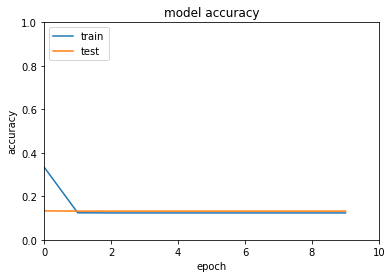

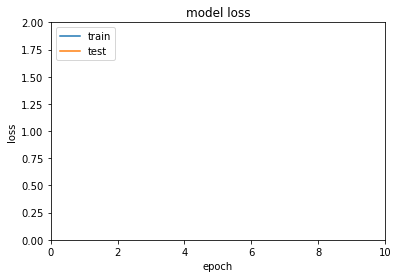

,English,French,Italian,German,Spanish
English,0,723,2,0,0
French,0,150,0,0,0
Italian,0,124,0,0,0
German,0,70,0,0,0
Spanish,0,67,0,0,0


In [19]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [20]:
names = names.append(names.sample(10000, replace=True))
names.count()

name    15676
lang    15676
dtype: int64

In [21]:
def handle_imbalance(names, languages):

    ### START YOUR CODE
    
    # find max. number of samples of all languages
    max_nr_samples = names.groupby('lang')['name'].count().max()

    # treat class imbalance
    for lang in languages:
      act_lang = names.loc[names['lang'] == lang]
      nr_samples = act_lang.count()[0]
      
      # resampling
      if (nr_samples < max_nr_samples):
        nr_resampled_samples = max_nr_samples - nr_samples
        
        resamples = act_lang.sample(nr_resampled_samples,
                                    replace=True)
        names = names.append(resamples)
      
    names_upsampled = names

    ### END YOUR CODE    
    return names_upsampled


In [22]:
names_upsampled = handle_imbalance(names, languages)
names_upsampled.groupby('lang')['name'].count()/len(names_upsampled)

lang
English    0.2
French     0.2
German     0.2
Italian    0.2
Spanish    0.2
Name: name, dtype: float64

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [23]:
### START YOUR CODE

X_train, X_test, y_train, y_test = train_test_split(names['name'],
                                                    names['lang'],
                                                    test_size=test_split,
                                                    shuffle=True)

## Run this cell only once!

# Map train data into vector space (one-hot-vectors)
X_train_tmp = []
y_train_tmp = []

for idx in range(len(X_train)):
  X_train_tmp.append(name_representation(X_train.iloc[idx], maxlen))
  y_train_tmp.append(lang_representation(y_train.iloc[idx], language_to_index))

X_train = np.array(X_train_tmp)
Y_train = np.vstack(y_train_tmp)

# Map test data into vector space (one-hot-vectors)
X_test_tmp = []
y_test_tmp = []

for idx in range(len(X_test)):
  X_test_tmp.append(name_representation(X_test.iloc[idx], maxlen))
  y_test_tmp.append(lang_representation(y_test.iloc[idx], language_to_index))

X_test = np.array(X_test_tmp)
Y_test = np.vstack(y_test_tmp)

### END YOUR CODE

In [24]:
### START YOUR CODE

# train model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

log = model.fit(X_train, Y_train, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/10
98/98 [==============================] - 1s 8ms/step - loss: 14.4791 - accuracy: 0.1199 - val_loss: 14.5351 - val_accuracy: 0.1288
Epoch 2/10
98/98 [==============================] - 1s 6ms/step - loss: 14.5162 - accuracy: 0.1243 - val_loss: 14.5351 - val_accuracy: 0.1288
Epoch 3/10
98/98 [==============================] - 1s 7ms/step - loss: 14.4540 - accuracy: 0.1299 - val_loss: 14.5351 - val_accuracy: 0.1288
Epoch 4/10
98/98 [==============================] - 1s 6ms/step - loss: 14.5259 - accuracy: 0.1245 - val_loss: 14.5351 - val_accuracy: 0.1288
Epoch 5/10
98/98 [==============================] - 1s 6ms/step - loss: 14.4960 - accuracy: 0.1224 - val_loss: 14.5351 - val_accuracy: 0.1288
Epoch 6/10
98/98 [==============================] - 1s 6ms/step - loss: 14.6145 - accuracy: 0.1211 - val_loss: 14.5351 - val_accuracy: 0.1288
Epoch 7/10
98/98 [==============================] - 1s 6ms/step - loss: 14.5344 - accuracy: 0.1223 - val_loss: 14.5351 - val_accuracy: 0.1288
Epoch 

Train accuracy (end): 0.12368421256542206
Train accuracy (max): 0.12368421256542206
Test accuracy (end) : 0.12882652878761292
Test accuracy (max) : 0.12882652878761292


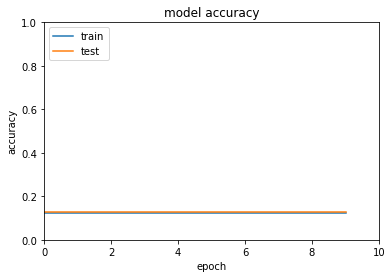

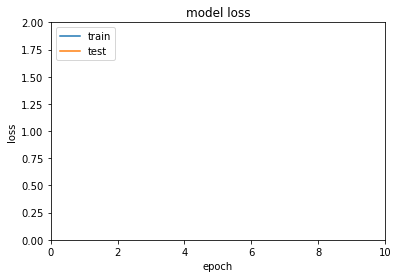

,English,French,Italian,German,Spanish
English,1,2020,4,0,0
French,1,402,2,0,0
Italian,0,396,1,0,0
German,1,162,0,0,0
Spanish,0,146,0,0,0


In [25]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings

...


#### In which situations is class imbalance treatment important and why?  

....

### Implement Model with several SimpleRNN Layers

In [26]:
### START YOUR CODE

model = Sequential()

# Input: names in numpy arrays of shape (*,maxlen,len_alphabet)
# Input: names in numpy arrays of shape (*,18,74)
model.add(Input((maxlen,len_alphabet)))

model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128))
model.add(Dense(len(languages)))

### END YOUR CODE

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 18, 128)           25984     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 18, 128)           32896     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 18, 128)           32896     
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 125,317
Trainable params: 125,317
Non-trainable params: 0
_________________________________________________________________


In [27]:
### START YOUR CODE

# train model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

log = model.fit(X_train, Y_train, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/10
98/98 [==============================] - 4s 24ms/step - loss: 9.4654 - accuracy: 0.5767 - val_loss: 10.4079 - val_accuracy: 0.6454
Epoch 2/10
98/98 [==============================] - 2s 21ms/step - loss: 5.9144 - accuracy: 0.6486 - val_loss: 5.7102 - val_accuracy: 0.6457
Epoch 3/10
98/98 [==============================] - 2s 22ms/step - loss: 5.7186 - accuracy: 0.6450 - val_loss: 5.7102 - val_accuracy: 0.6457
Epoch 4/10
98/98 [==============================] - 2s 22ms/step - loss: 5.6159 - accuracy: 0.6517 - val_loss: 5.7102 - val_accuracy: 0.6457
Epoch 5/10
98/98 [==============================] - 2s 21ms/step - loss: 5.6498 - accuracy: 0.6490 - val_loss: 5.7102 - val_accuracy: 0.6457
Epoch 6/10
98/98 [==============================] - 2s 21ms/step - loss: 5.6287 - accuracy: 0.6505 - val_loss: 5.7102 - val_accuracy: 0.6457
Epoch 7/10
98/98 [==============================] - 2s 21ms/step - loss: 5.7281 - accuracy: 0.6446 - val_loss: 5.7102 - val_accuracy: 0.6457
Epoch 8/10
9

Train accuracy (end): 0.6469696760177612
Train accuracy (max): 0.6469696760177612
Test accuracy (end) : 0.6457270383834839
Test accuracy (max) : 0.6457270383834839


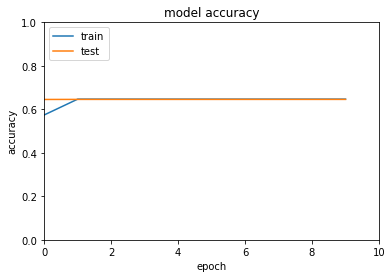

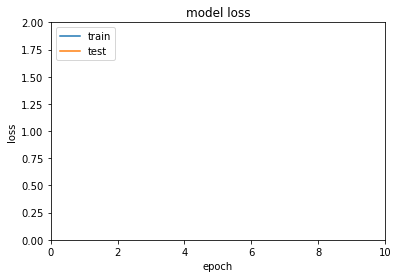

,English,French,Italian,German,Spanish
English,2024,0,1,0,0
French,404,1,0,0,0
Italian,397,0,0,0,0
German,163,0,0,0,0
Spanish,146,0,0,0,0


In [28]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings

...
